# 01 Degree Distribution

In [15]:
# ── Path-Fix for Imports ───────────────────────────────────────────────────
import sys
from pathlib import Path
# Prepend parent directory (repo root) to sys.path
sys.path.insert(0, str(Path().resolve().parent))

# ── Standard Imports ───────────────────────────────────────────────────────────
import pandas as pd
import numpy as np
import powerlaw
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from scripts.graph_utils import load_clean_df, build_unweighted_graph, build_weighted_graph

sns.set(style="whitegrid")

## Analysis goes here…

In [26]:
# adjust threshold or date‐slice as you like
THRESHOLD   = 0
START_DATE  = "2023-04-14"
END_DATE    = "2023-05-31"
USE_CACHE   = True
HIGHLIGHT_END = 13


In [8]:
# load the filtered DataFrame
df = load_clean_df(threshold=THRESHOLD,
                  start_date=START_DATE,
                  end_date=END_DATE)

# build (or load) the unweighted directed graph
G = build_unweighted_graph(df,
                           threshold=THRESHOLD,
                           start_date=START_DATE,
                           end_date=END_DATE,
                           use_cache=USE_CACHE)

print(f"Nodes: {G.number_of_nodes():,}, Edges: {G.number_of_edges():,}")


Nodes: 215,741, Edges: 426,954


In [17]:
# for directed graphs we can look at in-, out-, or total degree:
in_deg  = np.array([d for _, d in G.in_degree()])
out_deg = np.array([d for _, d in G.out_degree()])
tot_deg = in_deg + out_deg


In [18]:
# Some Summary Statistics
deg_stats = []
for name, arr in [("in", in_deg), ("out", out_deg), ("total", tot_deg)]:
    deg_stats.append({
        "type":       name,
        "mean":       arr.mean(),
        "median":     np.median(arr),
        "max":        arr.max(),
        "frac_deg1":  np.mean(arr == 1),
        "frac_≤5":    np.mean(arr <= 5),
        "frac_≥100":  np.mean(arr >= 100),
    })

stats_df = pd.DataFrame(deg_stats).set_index("type")
display(stats_df)

,mean,median,max,frac_deg1,frac_≤5,frac_≥100
type,,,,,,
in,1.979012,1.0,37799,0.781520,0.995657,0.000264
out,1.979012,1.0,70345,0.448301,0.995620,0.000306
total,3.958024,2.0,108144,0.368646,0.955595,0.000450


In [19]:
def plot_deg_hist_and_ccdf(deg, title):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    # Histogram
    axes[0].hist(deg, bins=np.logspace(0, np.log10(deg.max()), 50))
    axes[0].set_xscale('log')
    axes[0].set_yscale('log')
    axes[0].set_xlabel('Degree')
    axes[0].set_ylabel('Count')
    axes[0].set_title(f'{title} Histogram (log–log)')
    axes[0].grid(True, which="both", ls="--", lw=0.5)

    # CCDF
    sorted_deg = np.sort(deg)
    ccdf = 1.0 - np.arange(len(deg)) / len(deg)
    axes[1].loglog(sorted_deg, ccdf, marker='.', linestyle='none')
    axes[1].set_xlabel('Degree')
    axes[1].set_ylabel('CCDF')
    axes[1].set_title(f'{title} CCDF (log–log)')
    axes[1].grid(True, which="both", ls="--", lw=0.5)

    plt.tight_layout()
    plt.show()

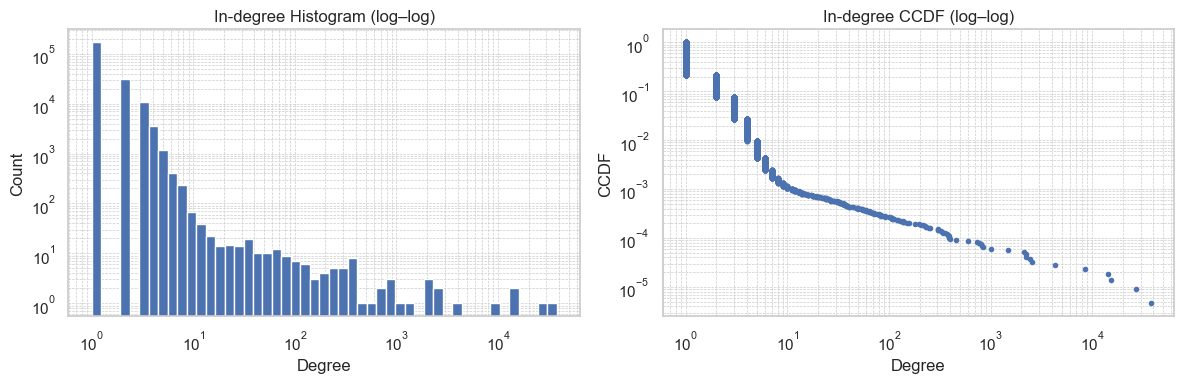

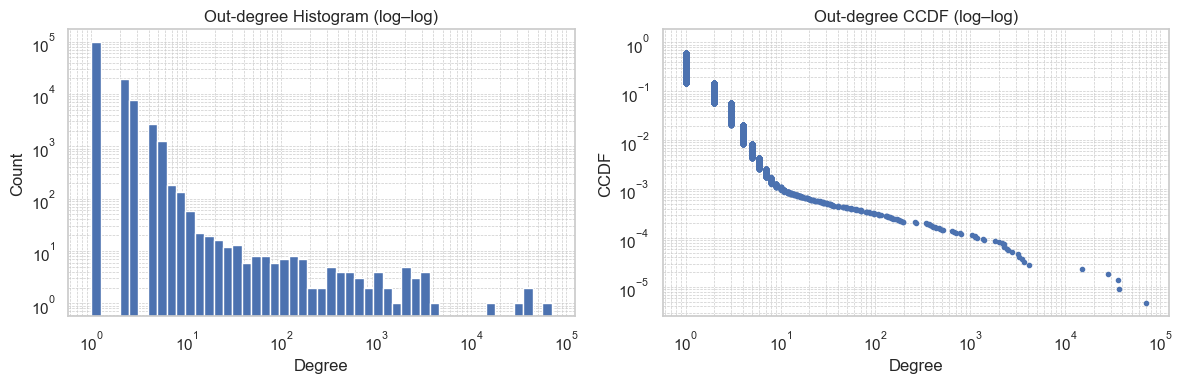

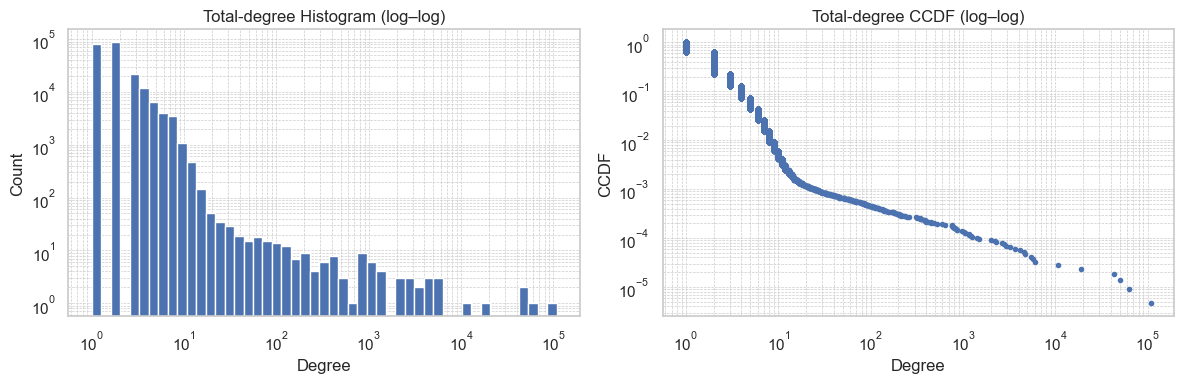

In [20]:
# Plot In-, Out-, and Total-Degree Distributions
for name, arr in [("In-degree", in_deg), ("Out-degree", out_deg), ("Total-degree", tot_deg)]:
    plot_deg_hist_and_ccdf(arr, name)

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Estimated α = 4.97 (xmin = 6.0)
Power-law vs lognormal:   R = 13.36, p = 9.52e-47
Power-law vs exponential: R = 29333.71, p = 3.23e-18


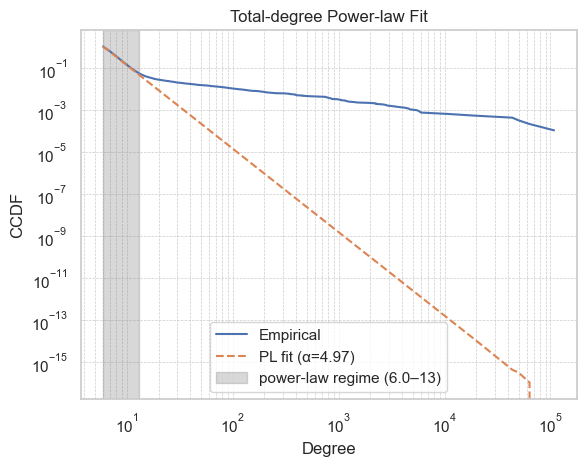

In [28]:
# Power-Law Fit on Total Degree
def fit_and_plot_tail(arr, highlight_end):
    arr_pos = arr[arr > 0]
    fit = powerlaw.Fit(arr_pos)
    alpha = fit.power_law.alpha
    xmin  = fit.power_law.xmin
    R_ln, p_ln = fit.distribution_compare("power_law", "lognormal")
    R_exp, p_exp = fit.distribution_compare("power_law", "exponential")

    print("Calculating best minimal value for power law fit")
    print(f"Estimated α = {alpha:.2f} (xmin = {xmin})")
    print(f"Power-law vs lognormal:   R = {R_ln:.2f}, p = {p_ln:.2e}")
    print(f"Power-law vs exponential: R = {R_exp:.2f}, p = {p_exp:.2e}")

    # Plot CCDF and fit
    ax = fit.plot_ccdf(label="Empirical")
    fit.power_law.plot_ccdf(
        ax=ax,
        linestyle="--",
        label=f"PL fit (α={alpha:.2f})"
    )
    # highlight only from xmin to highlight_end
    ax.axvspan(xmin, highlight_end, color="grey", alpha=0.3, label=f"power-law regime ({xmin}–{highlight_end})")
    ax.legend()
    ax.set_xlabel("Degree")
    ax.set_ylabel("CCDF")
    ax.set_title("Total-degree Power-law Fit")
    ax.grid(True, which="both", ls="--", lw=0.5)
    plt.show()

fit_and_plot_tail(tot_deg, HIGHLIGHT_END)

## Key Insights Generated

- **Network scale & sparsity**  
  – 215 741 wallets, 426 954 directed edges  
  – Graph density ≈ 9 × 10⁻⁶  
  – Self-loops (< 0.05 %) removed  

- **Degree fingerprints**  

  | Type   | Mean  | Median | Max     | % deg=1 | % ≤ 5  | % ≥ 100 |
  |:-------|------:|-------:|--------:|--------:|-------:|--------:|
  | Total  | 3.96  | 2      |108 144  | 36.9 %  | 95.6 % | 0.05 %  |

<br> 

- **Heavy-tailed behavior**  
  – **Power-law regime** (shaded) for **6 ≤ k ≤ 13**: clean straight-line CCDF, fit exponent α≈4.97  
  – **Extreme tail** (k > 13): few mega-hubs, finite-size & specialized-node effects cause deviation  
  – Power-law fit (α=4.97, xmin=6.0) strongly outperforms log-normal & exponential (R=13.36, p≈9.5 × 10⁻⁴⁷; R=2.93 × 10⁴, p≈3.2 × 10⁻¹⁸)

- **Meme-coin hype phase**  
  – Bulk of speculators (single/multiple small transfers) vs. a tiny “whale club” of exchanges and DEX routers  
  – The power-law regime captures the rich-get-richer dynamic among active speculators  
  – Deviation in the extreme tail is expected and doesn’t negate the core power-law behavior  

- **Next steps**  
  1. Global summaries (Notebook 02): connectivity, reciprocity, bow-tie  
  2. Weighted-degree & temporal snapshots  
  3. k-core & community structure analyses  
